In [1]:
import urllib
import operator
import sys
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import bootstrapped.bootstrap as bs
import scipy.stats as stats
import bootstrapped.stats_functions as bs_stats
from sklearn import preprocessing
from beautifultable import BeautifulTable
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
directoryToRead = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
columnNames = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
featureNames = []

directoryName = 'AReM'
baseURL = 'https://raw.githubusercontent.com/SurbhiJainUSC/Time-Series-Classification/master/'

trainDataUpperBound = [7, 6, 15, 15, 15, 15, 15]
testDataUpperBound = [2, 2, 3, 3, 3, 3, 3]

In [4]:
def readData(fileURL):
    data = []
    
    inputFile = urllib.request.urlopen(fileURL)
    cnt = 1
    for line in inputFile:
        line = line.decode('utf-8')
        if cnt<=5:
            cnt += 1
            continue
        else:
            columnData = line.split(',')
            if len(columnData)==1:
                columnData = line.split(' ')
            for j in range(1, len(columnData)):
                columnData[j] = columnData[j].replace('\n', '')
                columnData[j] = columnData[j].strip()
                if len(columnData[j])==0:
                    columnData.pop(j)
                    continue
                columnData[j] = float(columnData[j])
            data.append(columnData[1:])
    
    data = pd.DataFrame(data, columns=columnNames)
    return data

In [5]:
def getStatistics(data):
    statistics = data.describe()
    stats = {}
    stats['Mean'] = statistics[1:2].values[0].tolist()
    stats['Std'] = statistics[2:3].values[0].tolist()
    stats['Median'] = statistics[5:6].values[0].tolist()
    stats['Min'] = statistics[3:4].values[0].tolist()
    stats['Max'] = statistics[7:8].values[0].tolist()
    stats['FirstQuartile'] = statistics[4:5].values[0].tolist()
    stats['ThirdQuartile'] = statistics[6:7].values[0].tolist()
    return stats

In [6]:
# Print data in a tabular form
def printDatainTable(tableHeaders, tableData):
    table = BeautifulTable(max_width=100)
    table.set_style(BeautifulTable.STYLE_SEPARATED)
    if len(tableHeaders)!=0:
        table.column_headers = tableHeaders
    for i in range(0, len(tableData)):
        table.append_row(tableData[i])
    print(table)

In [7]:
def printConfusionMatrix(trueNegative, falsePositive, falseNegative, truePositive):
    tableData = []
    row1 = []
    row1.append('')
    row1.append('Predicted Bending')
    row1.append('Predicted Non-Bending')
    tableData.append(row1)
    
    row2 = []
    row2.append('Actual Bending')
    row2.append(truePositive)
    row2.append(falseNegative)
    tableData.append(row2)
    
    row3 = []
    row3.append('Actual Non-Bending')
    row3.append(falsePositive)
    row3.append(trueNegative)
    tableData.append(row3)
    
    printDatainTable([], tableData)

In [8]:
def multiClassROC(model, trainDataY, testDataX, testDataY):
    lb = preprocessing.LabelBinarizer()
    lb.fit(trainDataY)
    trainDataY = lb.transform(trainDataY)
    testDataY = lb.transform(testDataY)

    predictedProbY = model.predict_proba(testDataX)

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(0, 7):
        fpr[i], tpr[i], _ = roc_curve(testDataY[:, i], predictedProbY[:, i])
        roc_auc[i] = round(auc(fpr[i], tpr[i]), 2)

    for i in range(0, 7):
        className = directoryToRead[i]
        label = 'ROC of ' + className + ' AUC: ' + str(roc_auc[i])
        plt.plot(fpr[i], tpr[i], label=label)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend()
    return plt, roc_auc

In [9]:
def getMultiClassPredictions(classModels, trainDataX):
    predictions = []
    PredictionProbability = pd.DataFrame()
    for j in range(0, len(classModels)):
        classModel = classModels[j]
        predProb = classModel.predict_proba(trainDataX)
        predProbClass = []
        for i in range(0, len(predProb)):
            predProbClass.append(round(predProb[i][1], 3))
        predProbClass = pd.DataFrame(predProbClass, columns=[directoryToRead[j]])
        PredictionProbability = pd.concat([PredictionProbability, predProbClass], axis=1)

    for i in range(0, len(PredictionProbability)):
        maxProb = 0.0
        predClass = ''
        for j in range(0, len(directoryToRead)):
            prob = PredictionProbability[directoryToRead[j]][i]
            if prob>maxProb:
                maxProb = prob
                predClass = directoryToRead[j]
        predictions.append(directoryToRead.index(predClass))
        
    return predictions, PredictionProbability

# Read data and perform data cleaning.

In [10]:
data = {}
         
for i in range(0, len(directoryToRead)):
    for j in range(1, trainDataUpperBound[i]+1):
        fileName = directoryName + '/' + directoryToRead[i] + '/dataset' + str(j) + '.csv' 
        fileUrl = baseURL + fileName
        data[fileName] = readData(fileUrl)

            
for k,v in data.items():
    print('-------------------------------------------')
    print('File Name:', k)
    print('-------------------------------------------')
    print('Total observations:', len(v))
    print('-------------------------------------------')
    print('Total features:', len(v.columns))
    print('-------------------------------------------')
    print('First 5 observations:')
    print('-------------------------------------------')
    print(v.head())
    print()

-------------------------------------------
File Name: AReM/bending1/dataset1.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total features: 6
-------------------------------------------
First 5 observations:
-------------------------------------------
   avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0      39.25       0.43      22.75       0.43      33.75        1.3
1      39.25       0.43      23.00       0.00      33.00        0.0
2      39.25       0.43      23.25       0.43      33.00        0.0
3      39.50       0.50      23.00       0.71      33.00        0.0
4      39.50       0.50      24.00       0.00      33.00        0.0

-------------------------------------------
File Name: AReM/bending1/dataset2.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total features: 6
-------------------------------------------
First 5 obser

4      45.50       0.50      20.00       0.71      11.75       0.43

-------------------------------------------
File Name: AReM/standing/dataset8.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total features: 6
-------------------------------------------
First 5 observations:
-------------------------------------------
   avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0      48.00       0.00       6.75       3.77      11.00       1.22
1      47.75       0.43      11.50       0.50      10.00       1.00
2      48.00       0.00      11.25       0.43       8.67       0.47
3      48.00       0.00      11.67       0.47      11.00       1.41
4      48.00       0.00      10.25       1.79      12.00       0.00

-------------------------------------------
File Name: AReM/standing/dataset9.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total 

# Create train data.

In [11]:
trainData = {}

for i in range(0, len(directoryToRead)):
    start = testDataUpperBound[i]+1
    end = trainDataUpperBound[i]
    for j in range(start, end+1):
        fileName = directoryName + '/' + directoryToRead[i] + '/dataset' + str(j) + '.csv'
        trainData[fileName] = data[fileName]

for k,v in trainData.items():
    print('-------------------------------------------')
    print('File Name:', k)
    print('-------------------------------------------')
    print('Total observations:', len(v))
    print('-------------------------------------------')
    print('Total features:', len(v.columns))
    print('-------------------------------------------')
    print('First 5 observations:')
    print('-------------------------------------------')
    print(v.head())
    print()

-------------------------------------------
File Name: AReM/bending1/dataset3.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total features: 6
-------------------------------------------
First 5 observations:
-------------------------------------------
   avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0      42.00       0.71      21.25       0.43      30.00       0.00
1      41.50       0.50      20.25       1.48      31.25       1.09
2      41.50       0.50      14.25       1.92      33.00       0.00
3      40.75       0.83      15.75       0.43      33.00       0.00
4      40.00       0.71      20.00       2.74      32.75       0.43

-------------------------------------------
File Name: AReM/bending1/dataset4.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total features: 6
-------------------------------------------
First 5 obser

4      38.00       0.71      16.00       1.87      14.00       3.24

-------------------------------------------
File Name: AReM/sitting/dataset12.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total features: 6
-------------------------------------------
First 5 observations:
-------------------------------------------
   avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0      42.50       0.50       8.33       3.30      16.50       2.60
1      42.75       0.83      13.50       1.12      17.25       0.83
2      42.25       0.43      12.00       0.00      19.00       0.82
3      42.50       0.50       4.50       2.50      18.00       0.00
4      42.25       0.43       6.67       4.11      18.75       0.83

-------------------------------------------
File Name: AReM/sitting/dataset13.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total 

4      41.00       0.71      13.00       3.39      13.50       7.02

-------------------------------------------
File Name: AReM/walking/dataset11.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total features: 6
-------------------------------------------
First 5 observations:
-------------------------------------------
   avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0      42.33       3.40      16.25       3.11      18.00       2.45
1      30.25       6.94      22.25       3.03      16.75       5.49
2      30.00       5.72      20.50       3.04      22.33       1.25
3      35.67       5.31      16.67       1.25      21.00       2.55
4      39.00       1.22      17.75       2.77      21.50       0.87

-------------------------------------------
File Name: AReM/walking/dataset12.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total 

# Create test data.

In [12]:
testData = {}

for i in range(0, len(directoryToRead)):
    start = 1
    end = testDataUpperBound[i]
    for j in range(start, end+1):
        fileName = directoryName + '/' + directoryToRead[i] + '/dataset' + str(j) + '.csv'
        testData[fileName] = data[fileName]

for k,v in testData.items():
    print('-------------------------------------------')
    print('File Name:', k)
    print('-------------------------------------------')
    print('Total observations:', len(v))
    print('-------------------------------------------')
    print('Total features:', len(v.columns))
    print('-------------------------------------------')
    print('First 5 observations:')
    print('-------------------------------------------')
    print(v.head())
    print()

-------------------------------------------
File Name: AReM/bending1/dataset1.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total features: 6
-------------------------------------------
First 5 observations:
-------------------------------------------
   avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0      39.25       0.43      22.75       0.43      33.75        1.3
1      39.25       0.43      23.00       0.00      33.00        0.0
2      39.25       0.43      23.25       0.43      33.00        0.0
3      39.50       0.50      23.00       0.71      33.00        0.0
4      39.50       0.50      24.00       0.00      33.00        0.0

-------------------------------------------
File Name: AReM/bending1/dataset2.csv
-------------------------------------------
Total observations: 480
-------------------------------------------
Total features: 6
-------------------------------------------
First 5 obser

# 1.c(i): Time-domain features used in time-series classification.
1. **Statistical Features:** <br/>
    a. Mean <br/>
    b. Median <br/>
    c. Standard Deviation <br/>
    d. Skewness, Kurtosis <br/>
    e. Minimum and Maximum <br/>
2. **Time Series Analysis Related Features:** <br/>
    a. Cross Correlation <br/>
    b. Auto Correlation <br/>
    c. Parameters of Autoregressive (AR) part of Autoregressive Integrated Moving Average (ARIMA) model <br/>
    d. Parameters of Moving Average (MA) part of ARIMA model <br/>
    e. Orders of AR, Integrated (I) and MA part of ARIMA model <br/>

# Extract statistical time-domain features for all 6 time series in each instance.

In [13]:
timeDomainData = []
for k,v in data.items():
    activity = k.split('/')[1]
    stats = getStatistics(v)
    means = stats['Mean']
    stds = stats['Std']
    medians = stats['Median']
    minValues = stats['Min']
    maxValues = stats['Max']
    firstQuartiles = stats['FirstQuartile']
    thirdQuartiles = stats['ThirdQuartile']
    
    if len(featureNames)==0:
        for i in range(0, len(columnNames)):
            featureNames.append('Min_' + columnNames[i])
            featureNames.append('Max_' + columnNames[i])
            featureNames.append('Mean_' + columnNames[i])
            featureNames.append('Median_' + columnNames[i])
            featureNames.append('Std_' + columnNames[i])
            featureNames.append('FirstQuartile_' + columnNames[i])
            featureNames.append('ThirdQuartile_' + columnNames[i])
    
    row = []
    for i in range(0, len(columnNames)):
        row.append(minValues[i])
        row.append(maxValues[i])
        row.append(means[i])
        row.append(medians[i])
        row.append(stds[i])
        row.append(firstQuartiles[i])
        row.append(thirdQuartiles[i])
    row.append(activity)
    timeDomainData.append(row)
     
timeDomainDataColumns = []
timeDomainDataColumns = featureNames[:]
timeDomainDataColumns.append('Activity')
timeDomainData = pd.DataFrame(timeDomainData, columns=timeDomainDataColumns)

print('--------------------------------------------------')
print('Total observations in time-domain feature data:', len(timeDomainData))
print('--------------------------------------------------')
print('Total features in time-domain feature data:', len(featureNames))
print('--------------------------------------------------')
print('First 5 observations in time-domain feature data:')
print('--------------------------------------------------')
print(timeDomainData[featureNames].head())

--------------------------------------------------
Total observations in time-domain feature data: 88
--------------------------------------------------
Total features in time-domain feature data: 42
--------------------------------------------------
First 5 observations in time-domain feature data:
--------------------------------------------------
   Min_avg_rss12  Max_avg_rss12  Mean_avg_rss12  Median_avg_rss12  \
0          37.25          45.00       40.624792             40.50   
1          38.00          45.67       42.812812             42.50   
2          35.00          47.40       43.954500             44.33   
3          33.00          47.75       42.179812             43.50   
4          33.00          45.75       41.678063             41.75   

   Std_avg_rss12  FirstQuartile_avg_rss12  ThirdQuartile_avg_rss12  \
0       1.476967                    39.25                    42.00   
1       1.435550                    42.00                    43.67   
2       1.558835       

# Standard deviation of all time-domain features.

In [14]:
stats = timeDomainData[featureNames].describe()
stds = stats[2:3].values[0].tolist()
tableHeaders = ['Feature Name', 'Standard Deviation']
tableData = []
for i in range(0, len(featureNames)):
    row = []
    row.append(featureNames[i])
    row.append(stds[i])
    tableData.append(row)

print('STANDARD DEVIATION OF TIME-DOMAIN FEATURES:')
printDatainTable(tableHeaders, tableData)

STANDARD DEVIATION OF TIME-DOMAIN FEATURES:
+=========================+====================+
|      Feature Name       | Standard Deviation |
+=========================+====================+
|      Min_avg_rss12      |        9.57        |
+-------------------------+--------------------+
|      Max_avg_rss12      |       4.394        |
+-------------------------+--------------------+
|     Mean_avg_rss12      |       5.336        |
+-------------------------+--------------------+
|    Median_avg_rss12     |        5.44        |
+-------------------------+--------------------+
|      Std_avg_rss12      |       1.772        |
+-------------------------+--------------------+
| FirstQuartile_avg_rss12 |       6.154        |
+-------------------------+--------------------+
| ThirdQuartile_avg_rss12 |       5.139        |
+-------------------------+--------------------+
|      Min_var_rss12      |        0.0         |
+-------------------------+--------------------+
|      Max_var_rss12     

# 90% bootstrap confidence interval for standard deviation of each feature.

In [15]:
tableData = []
for i in range(0, len(featureNames)):
    row = []
    samples = np.array(timeDomainData[featureNames[i]])
    bootResult = bs.bootstrap(samples, stat_func=bs_stats.std, alpha=0.1)
    row.append(featureNames[i])
    row.append(stds[i])
    row.append(bootResult.lower_bound)
    row.append(bootResult.upper_bound)
    tableData.append(row)
    
print('STANDARD DEVIATION & 90% CONFIDENCE INTERVAL OF TIME-DOMAIN FEATURES:')
tableHeader = ['Feature Name', 'Standard Deviation', 'Lower Bound', 'Upper Bound']
printDatainTable(tableHeader, tableData)

STANDARD DEVIATION & 90% CONFIDENCE INTERVAL OF TIME-DOMAIN FEATURES:
+=========================+====================+=============+=============+
|      Feature Name       | Standard Deviation | Lower Bound | Upper Bound |
+=========================+====================+=============+=============+
|      Min_avg_rss12      |        9.57        |    8.329    |   10.804    |
+-------------------------+--------------------+-------------+-------------+
|      Max_avg_rss12      |       4.394        |    3.468    |    5.426    |
+-------------------------+--------------------+-------------+-------------+
|     Mean_avg_rss12      |       5.336        |    4.77     |    5.913    |
+-------------------------+--------------------+-------------+-------------+
|    Median_avg_rss12     |        5.44        |    4.85     |    6.044    |
+-------------------------+--------------------+-------------+-------------+
|      Std_avg_rss12      |       1.772        |    1.584    |    1.962    |
+-----

# Select 3 most important time-domain features.
**1. Mean:** It is the best measure of central tendency when the data distribution is continuous. <br/>
**2. Median:** It is a good feature of central tendency that is less affected by outliers and skewed data. <br/>
**3. Standard Deviation:** It is an ideal measure of dispersion. 

# Scatterplot for selected time-domain features for time-series 1, 2 and 6.

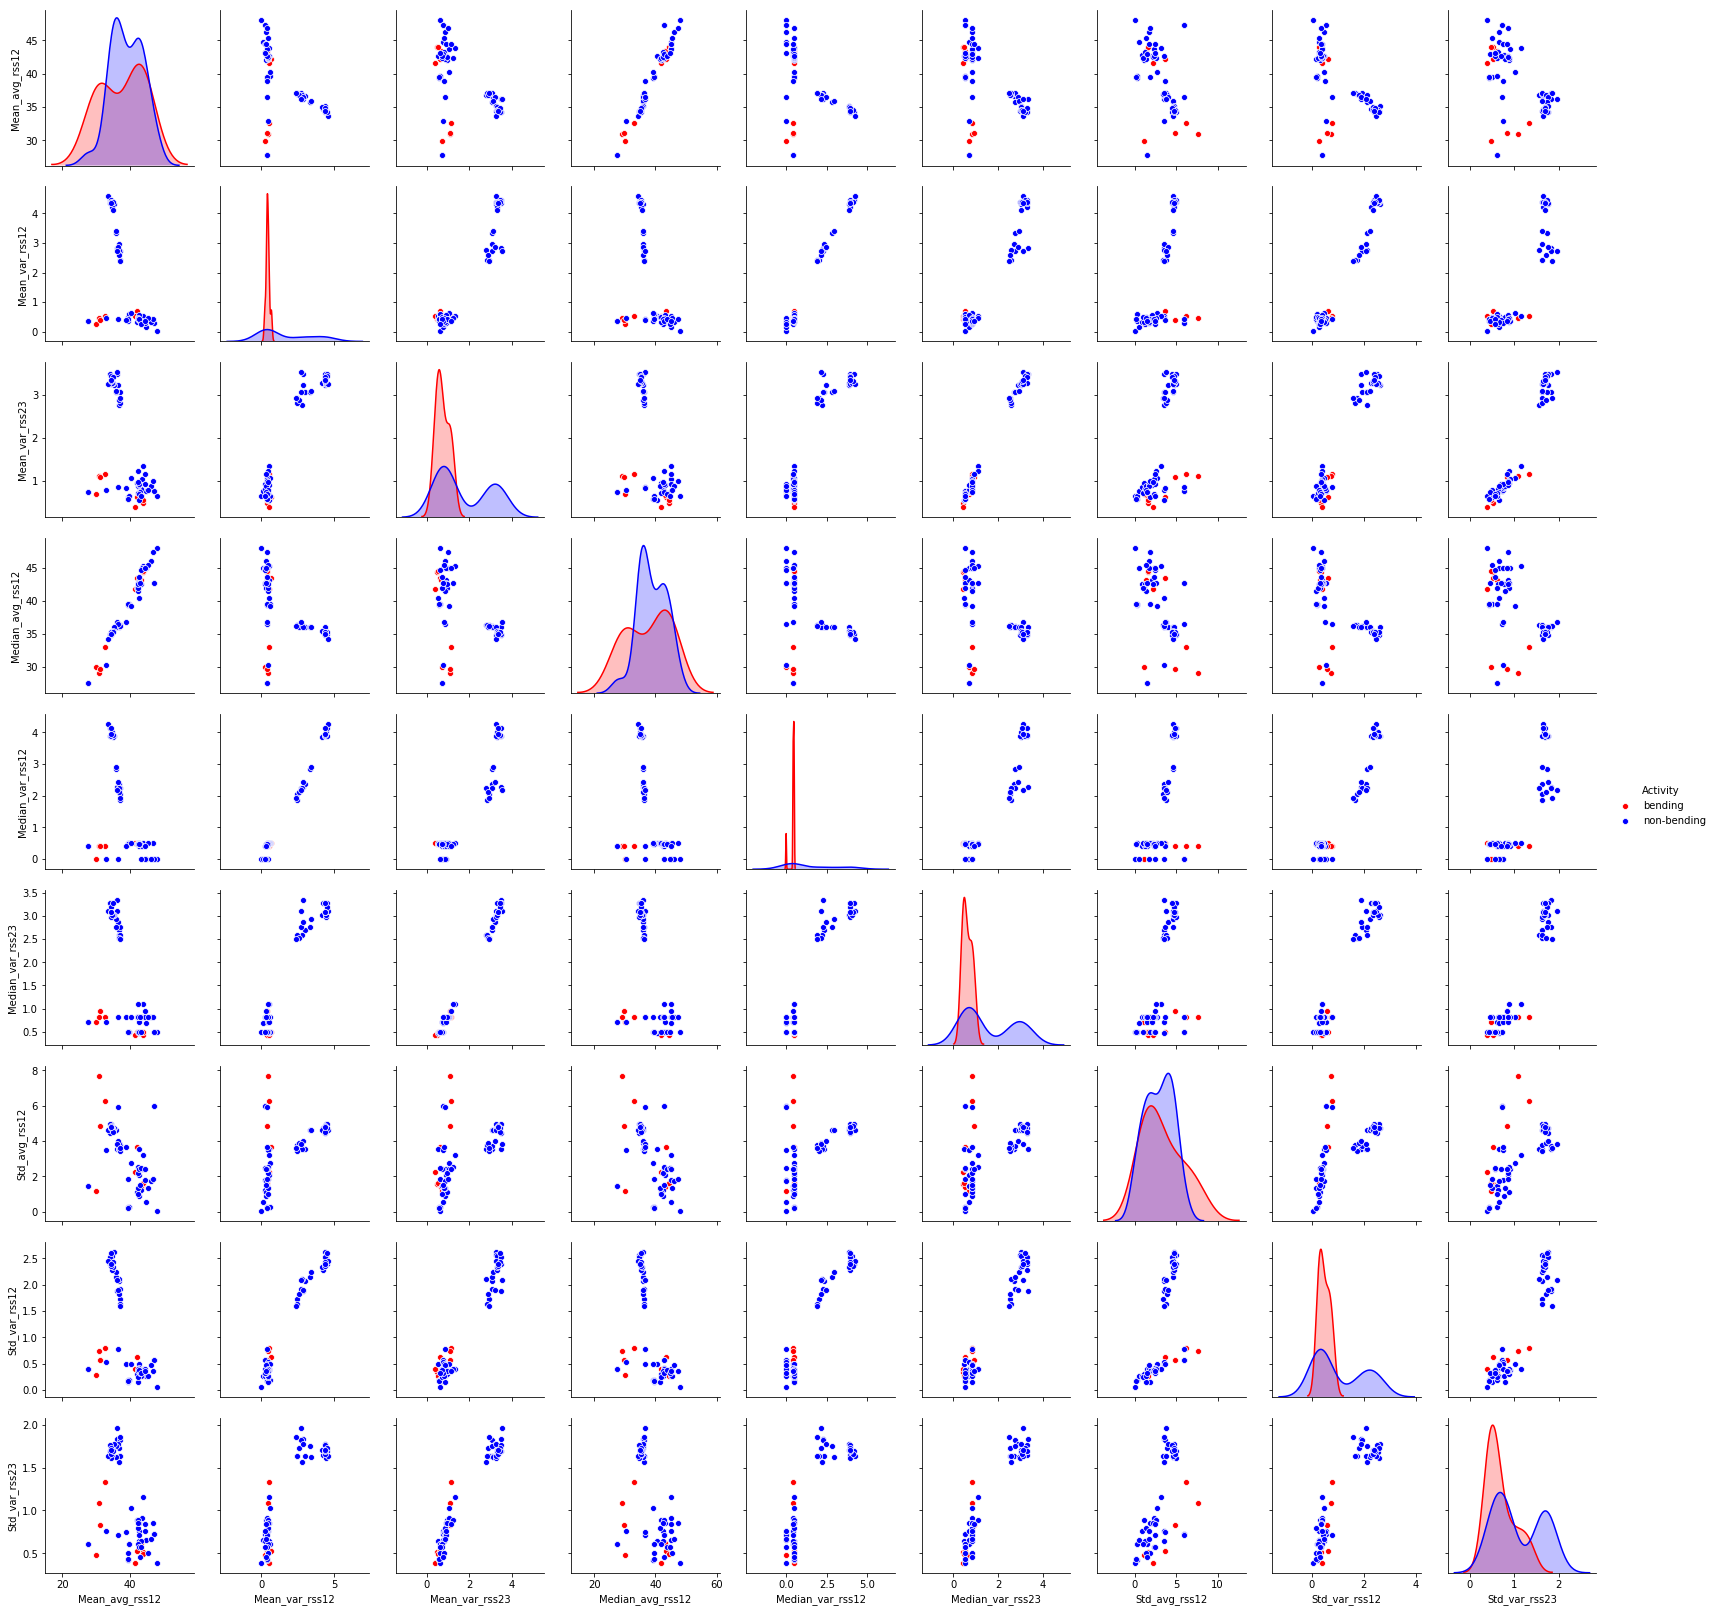

In [16]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 6]
featuresToPlot = []
trainDataDF = []

for k,v in trainData.items():
    activity = k.split('/')[1]
    stats = getStatistics(v)
    row = []
    for feature in selectedFeatures:
        dataFeaturesStats = stats[feature]
        for j in range(0, 6):
            if (j+1) in featuresToTake:
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake):
                    featuresToPlot.append(feature + '_' + columnNames[j])
                row.append(dataFeaturesStats[j])
    if activity=='bending1' or activity=='bending2':
        row.append('bending')
    else:
        row.append('non-bending')
    trainDataDF.append(row)

featuresToPlot.append('Activity')
trainDataDF = pd.DataFrame(trainDataDF, columns=featuresToPlot)

sbn.pairplot(data=trainDataDF, hue='Activity', palette={'bending':'red','non-bending':'blue'})

MORE DETAILED SCATTER PLOT:


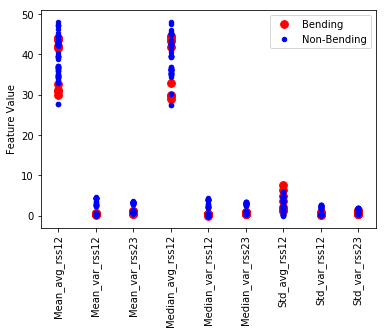

In [17]:
bendingData = []
nonBendingData = []
for i in range(0, len(trainDataDF)):
    for j in range(0, len(featuresToPlot)-1):
        feature = featuresToPlot[j]
        row = []
        row.append(feature)
        row.append(trainDataDF[feature][i])
        activity = trainDataDF['Activity'][i]
        if activity=='bending':
            bendingData.append(row[:])
        else:
            nonBendingData.append(row[:])

bendingData = pd.DataFrame(bendingData, columns=['FeatureName', 'FeatureValue'])
nonBendingData = pd.DataFrame(nonBendingData, columns=['FeatureName', 'FeatureValue'])

print('MORE DETAILED SCATTER PLOT:')
plt.scatter(bendingData['FeatureName'], bendingData['FeatureValue'], c='red', label='Bending', s=60)
plt.scatter(nonBendingData['FeatureName'], nonBendingData['FeatureValue'], c='blue', label='Non-Bending', s=20)
plt.xticks(featuresToPlot[:len(featuresToPlot)-1],rotation='vertical')
plt.ylabel('Feature Value')
plt.legend()
plt.show()

# Break time series into 2 approximately equal length time series and depict scatterplot for selected time-domain features for time series 1, 2 & 12.

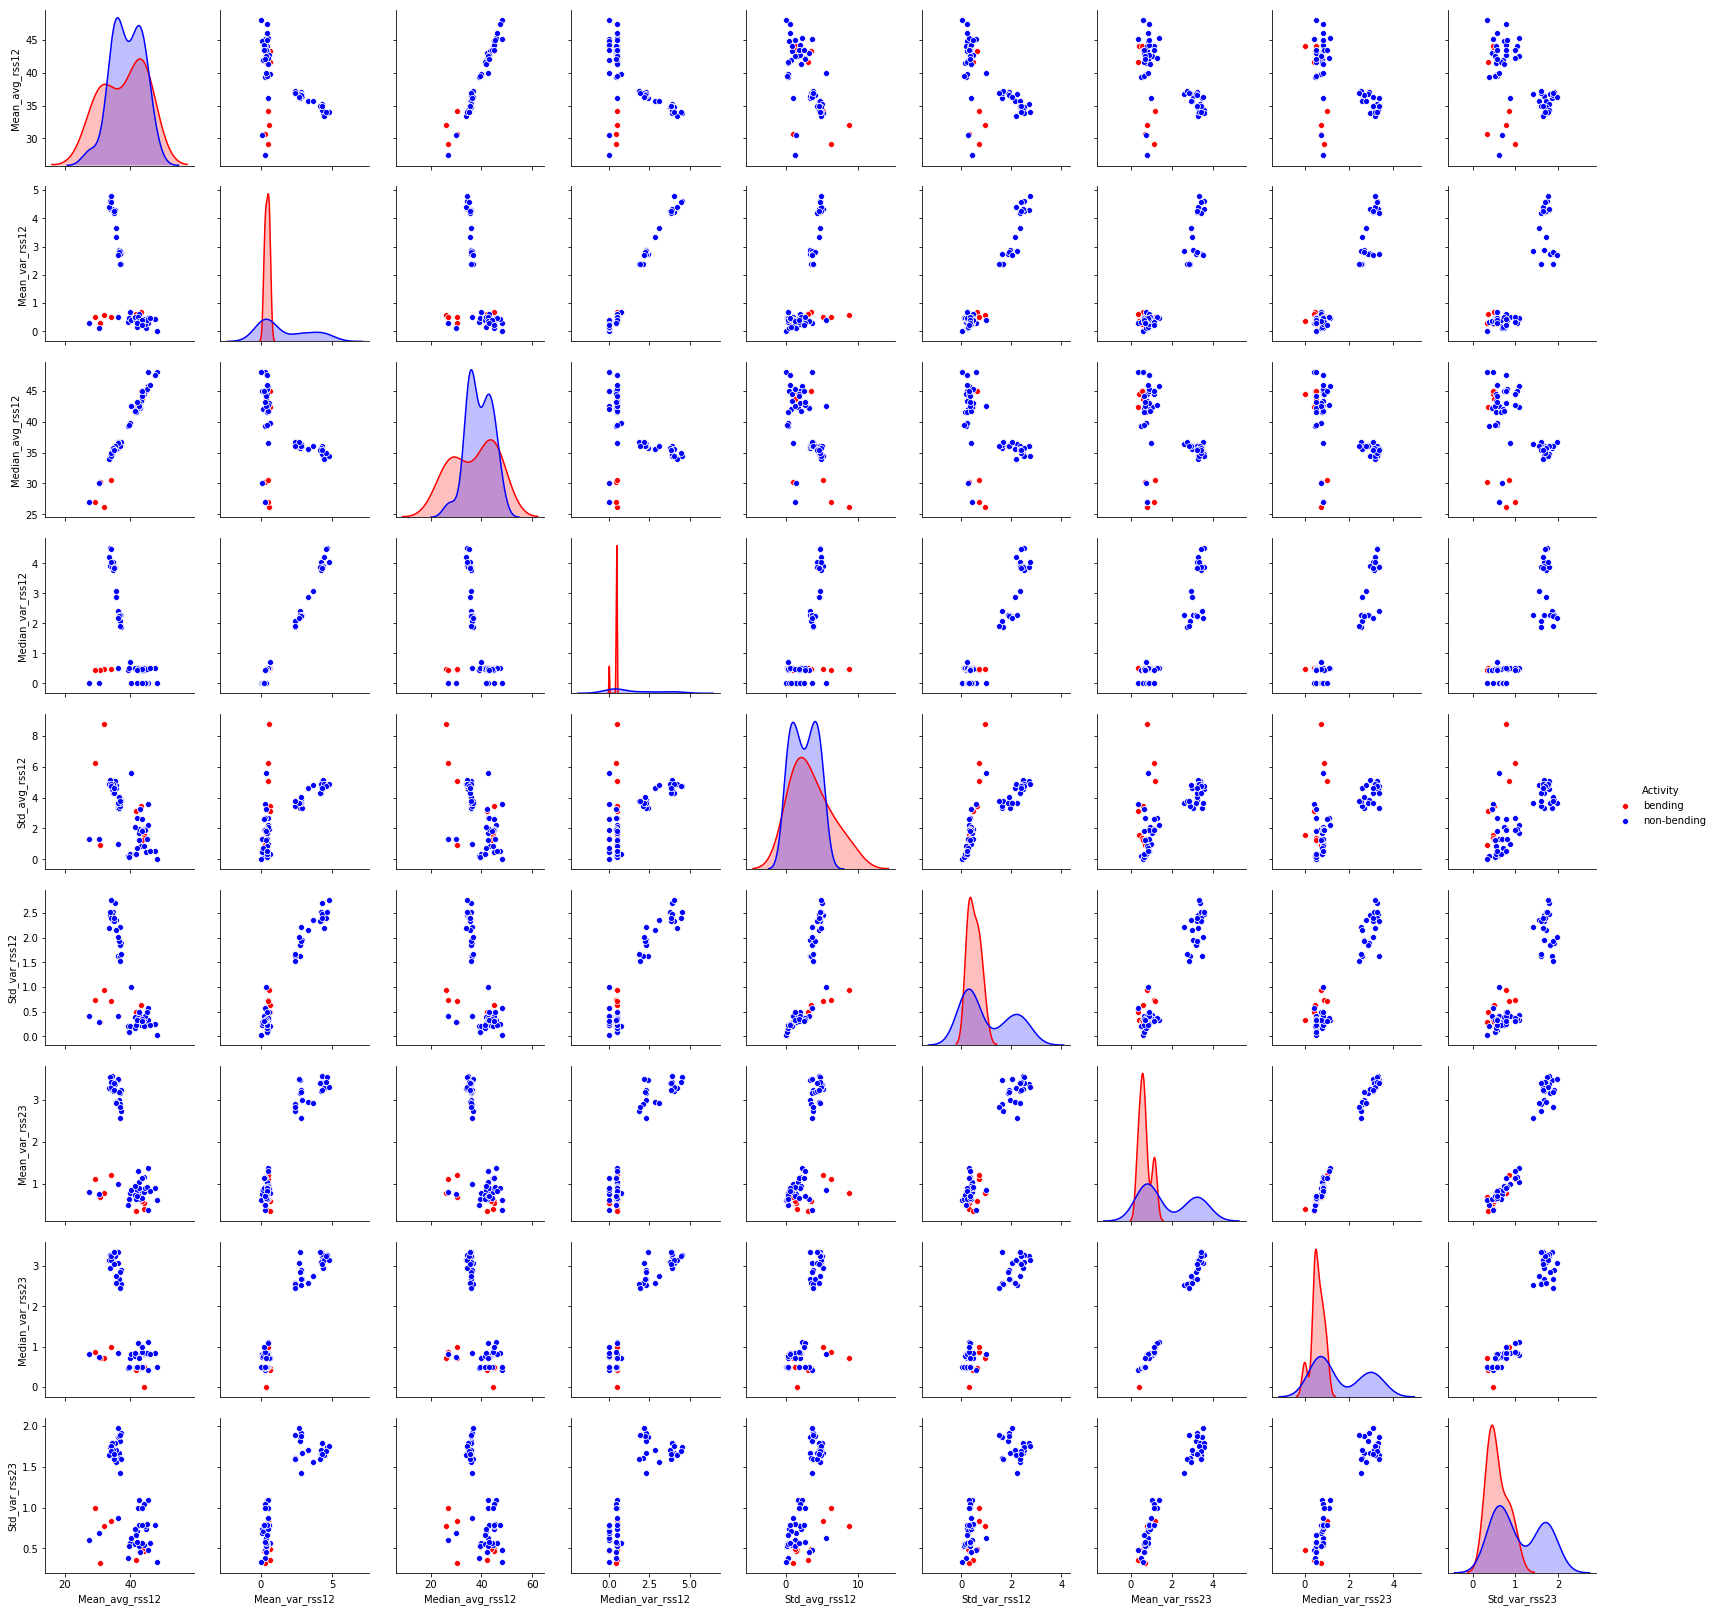

In [18]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 12]
featuresToPlot = []
trainDataDF = []

for k,v in trainData.items():
    cnt = 0
    activity = k.split('/')[1]
    splits = np.array_split(v, 2)
    row = []
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if (i+cnt+1) in featuresToTake:
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake):
                        featuresToPlot.append(feature + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])    
        cnt += 6
        
    if activity=='bending1' or activity=='bending2':
        row.append('bending')
    else:
        row.append('non-bending')
    trainDataDF.append(row)

featuresToPlot.append('Activity')
trainDataDF = pd.DataFrame(trainDataDF, columns=featuresToPlot)

sbn.pairplot(data=trainDataDF, hue='Activity', palette={'bending':'red','non-bending':'blue'})

MORE DETAILED SCATTER PLOT:


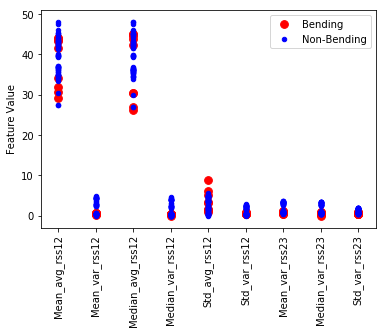

In [19]:
bendingData = []
nonBendingData = []
for i in range(0, len(trainDataDF)):
    for j in range(0, len(featuresToPlot)-1):
        feature = featuresToPlot[j]
        row = []
        row.append(feature)
        row.append(trainDataDF[feature][i])
        activity = trainDataDF['Activity'][i]
        if activity=='bending':
            bendingData.append(row[:])
        else:
            nonBendingData.append(row[:])

bendingData = pd.DataFrame(bendingData, columns=['FeatureName', 'FeatureValue'])
nonBendingData = pd.DataFrame(nonBendingData, columns=['FeatureName', 'FeatureValue'])

print('MORE DETAILED SCATTER PLOT:')
plt.scatter(bendingData['FeatureName'], bendingData['FeatureValue'], c='red', label='Bending', s=60)
plt.scatter(nonBendingData['FeatureName'], nonBendingData['FeatureValue'], c='blue', label='Non-Bending', s=20)
plt.xticks(featuresToPlot[:len(featuresToPlot)-1],rotation='vertical')
plt.ylabel('Feature Value')
plt.legend()
plt.show()

## **Findings:** 
After we break each time series into two equal-length time series, the scatterplot of both the classes (bending and non-bending) is more separable and easy to visualize.

# Break each time series in training data into L={1,2,...20} time series and fit logistic regression to find best L and best features. 

In [20]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

LRTableData = []
bestFeaturesL = {}
trainDataL = {}
for L in range(1, 21):
    featuresToPlot = []
    trainDataDF = []

    for k,v in trainData.items():
        activity = k.split('/')[1]
        splits = np.array_split(v, L)
        row = []
        splitNum = 1
        for split in splits:
            stats = getStatistics(split)
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for i in range(0, 6):
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])  
                    
            splitNum += 1

        if activity=='bending1' or activity=='bending2':
            row.append(1)
        else:
            row.append(0)
        trainDataDF.append(row)

    featuresToPlot.append('Activity')
    trainDataDF = pd.DataFrame(trainDataDF, columns=featuresToPlot)

    accuracy = []
    areaUnderCurve = []
    foldFeatures = []
    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    for trainIdx, valIdx in stratifiedKFolds.split(trainDataDF[featuresToPlot], trainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(trainDataDF[featuresToPlot].iloc[idx])    
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)
        
        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(trainDataDF[featuresToPlot].iloc[idx])    
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)
        
        # Select best predictors
        logRegModel1 = LogisticRegression(solver='liblinear', C=sys.maxsize)
        rfecvModel = RFECV(estimator=logRegModel1, cv=StratifiedKFold(5))
        rfecvModel.fit(trainX, trainY)
        ranking = rfecvModel.ranking_
        bestFeatures = []
        for i in range(0, len(ranking)):
            if ranking[i]==1:
                bestFeatures.append(featuresToPlot[i])
        
        newTrainX = trainX.loc[:,bestFeatures]
        newValX = valX.loc[:,bestFeatures]
        
        # Retrain logistic regression with best predictors
        logRegModel2 = LogisticRegression(solver='liblinear', C=sys.maxsize)
        logRegModel2 = logRegModel2.fit(newTrainX, trainY)
        
        # Find accuracy on cross-validation data
        validationAccuracy = logRegModel2.score(newValX, valY)
        validationPredictedYProb = logRegModel2.predict_proba(newValX)[::,1]
        validationAUC = roc_auc_score(valY, validationPredictedYProb)
        
        accuracy.append(validationAccuracy)
        areaUnderCurve.append(validationAUC)
        foldFeatures.append(bestFeatures)
        
    row = []
    row.append(L)
    row.append(np.mean(accuracy))
    row.append(np.mean(areaUnderCurve))
    kFoldIdx = np.argmax(areaUnderCurve)
    bestFeaturesL[L] = foldFeatures[kFoldIdx]
    trainDataL[L] = trainDataDF
    
    LRTableData.append(row)
    

tableHeaders = ['L', 'Accuracy', 'Area Under Curve']
printDatainTable(tableHeaders, LRTableData)

+====+==========+==================+
| L  | Accuracy | Area Under Curve |
+====+==========+==================+
| 1  |  0.942   |      0.983       |
+----+----------+------------------+
| 2  |  0.899   |      0.975       |
+----+----------+------------------+
| 3  |  0.943   |      0.983       |
+----+----------+------------------+
| 4  |  0.957   |      0.983       |
+----+----------+------------------+
| 5  |  0.929   |       0.95       |
+----+----------+------------------+
| 6  |  0.929   |      0.917       |
+----+----------+------------------+
| 7  |   0.9    |      0.933       |
+----+----------+------------------+
| 8  |  0.929   |      0.975       |
+----+----------+------------------+
| 9  |  0.929   |       1.0        |
+----+----------+------------------+
| 10 |  0.971   |      0.892       |
+----+----------+------------------+
| 11 |  0.943   |      0.992       |
+----+----------+------------------+
| 12 |  0.929   |      0.967       |
+----+----------+------------------+
|

In [21]:
maxLRAUC = LRTableData[0][2]
LRBestL = 1
for i in range(1, len(LRTableData)):
    if LRTableData[i][2]>maxLRAUC:
        maxLRAUC = LRTableData[i][2]
        LRBestL = LRTableData[i][0]

bestSelectedFeatures = bestFeaturesL[LRBestL]
print('------------------------------------------------------------------')
print('BEST L based on AUC:', LRBestL)
print('------------------------------------------------------------------')

print('BEST FEATURES:')
tableData = []
for i in range(0, len(bestSelectedFeatures)):
    row = []
    row.append(bestSelectedFeatures[i])
    tableData.append(row)

tableHeaders = ['Feature Name']
printDatainTable(tableHeaders, tableData)

------------------------------------------------------------------
BEST L based on AUC: 9
------------------------------------------------------------------
BEST FEATURES:
+=========================+
|      Feature Name       |
+=========================+
|  Mean_Split3_avg_rss23  |
+-------------------------+
| Median_Split7_avg_rss12 |
+-------------------------+


I have preferred Area Under Curve (AUC) over Accuracy to find out the best (L, P) pair because AUC is insensitive to imbalanced classes. 

# Report confusion matrix, ROC, AUC, Coefficients and p-values of final logistic regression model.

In [22]:
newTrainX = trainDataL[LRBestL][bestSelectedFeatures]
newTrainY = trainDataL[LRBestL]['Activity']

# Refit Logistic Regression on best (L, P) pair
logRegModel = LogisticRegression(solver='liblinear', C=sys.maxsize)
logRegModel = logRegModel.fit(newTrainX, newTrainY)

# coefficients
coefficients = logRegModel.coef_[0]

# p-values
_, pValues = chi2(newTrainX, newTrainY)

for i in range(0, len(pValues)):
    pValues[i] = round(pValues[i], 3)
    coefficients[i] = round(coefficients[i], 3)

tableData = []
for i in range(0, len(bestSelectedFeatures)):
    row = []
    row.append(bestSelectedFeatures[i])
    row.append(coefficients[i])
    row.append(pValues[i])
    tableData.append(row)
    
tableHeaders = ['Feature Name', 'Coefficient', 'p-value']
print('COEFFICIENT & P-VALUE FOR BEST FEATURES:')
printDatainTable(tableHeaders, tableData)

COEFFICIENT & P-VALUE FOR BEST FEATURES:
+=========================+=============+=========+
|      Feature Name       | Coefficient | p-value |
+=========================+=============+=========+
|  Mean_Split3_avg_rss23  |    17.23    |   0.0   |
+-------------------------+-------------+---------+
| Median_Split7_avg_rss12 |   -8.012    |  0.205  |
+-------------------------+-------------+---------+


CONFUSION MATRIX FOR TRAINING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |         9         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         0         |          60           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
1.0
------------------------------------------------------------------
AREA UNDER CURVE FOR TRAINING DATA:
1.0
------------------------------------------------------------------
ROC FOR TRAINING DATA:


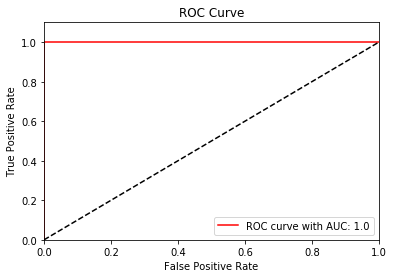

In [23]:
# predictions on training data
predictedY = logRegModel.predict(newTrainX)


# Confusion Matrix
print('CONFUSION MATRIX FOR TRAINING DATA:')
LRTrueNegative, LRFalsePositive, LRFalseNegative, LRTruePositive = confusion_matrix(newTrainY, predictedY).ravel()
printConfusionMatrix(LRTrueNegative, LRFalsePositive, LRFalseNegative, LRTruePositive)
print('------------------------------------------------------------------')
    

# Accuracy on training data
LRTrainAccuracy = logRegModel.score(newTrainX, newTrainY)
LRTrainAccuracy = round(LRTrainAccuracy, 3)
print('ACCURACY FOR TRAINING DATA:')
print(LRTrainAccuracy)
print('------------------------------------------------------------------')


# AUC value on training data
predictedYProb = logRegModel.predict_proba(newTrainX)[::,1]
LRfpr, LRtpr, _ = roc_curve(newTrainY,  predictedYProb)
LRTrainAUC = roc_auc_score(newTrainY, predictedYProb)
LRTrainAUC = round(LRTrainAUC, 3)
print('AREA UNDER CURVE FOR TRAINING DATA:')
print(LRTrainAUC)
print('------------------------------------------------------------------')


# ROC curve
print('ROC FOR TRAINING DATA:')
plt.plot(LRfpr, LRtpr, color='red', label='ROC curve with AUC: ' + str(LRTrainAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

# Compare accuracy of logistic regression model on testing data and cross-validation data.

In [24]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
LRTestDataDF = []
for k,v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, LRBestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*LRBestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])  

        splitNum += 1

    if activity=='bending1' or activity=='bending2':
        row.append(1)
    else:
        row.append(0)
    LRTestDataDF.append(row)

featuresToPlot.append('Activity')
LRTestDataDF = pd.DataFrame(LRTestDataDF, columns=featuresToPlot)
LRTestDataX = LRTestDataDF[bestSelectedFeatures]
LRTestDataY = LRTestDataDF['Activity']

# Accuracy on test data
LRTestAccuracy = logRegModel.score(LRTestDataX, LRTestDataY)
LRTestAccuracy = round(LRTestAccuracy, 3)

# Cross-validation Accuracy
LRValidationAccuracy = 0
for i in range(0, len(LRTableData)):
    if LRTableData[i][0]==LRBestL:
        LRValidationAccuracy = round(LRTableData[i][1], 3)
        break

tableData = []
row = []
row.append(LRBestL)
row.append(LRTestAccuracy)
row.append(LRValidationAccuracy)
tableData.append(row)
tableHeaders = ['Best L', 'Testing Accuracy', 'Cross-Validation Accuracy']
printDatainTable(tableHeaders, tableData)

+========+==================+===========================+
| Best L | Testing Accuracy | Cross-Validation Accuracy |
+========+==================+===========================+
|   9    |      0.895       |           0.929           |
+--------+------------------+---------------------------+


## **Findings:** 
The test accuracy is around 90%, so the model is performing well on test data.

# Analysis
The classes (bending and non-bending) are not well separated. So, when we use K-fold Cross Validation, there is a possiblity that some folds may not get any samples from the minority class. So, to solve this problem, Stratified K-fold Cross Validation has been used to take care of class imbalance. Also, Stratified K-fold Cross Validation has reduced the instability in calculating the logistic regression parameters.

# From the confusion matrices you obtained, do you see imbalanced classes?

CONFUSION MATRIX FOR TESTING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |         4         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         2         |          13           |
+--------------------+-------------------+-----------------------+
AREA UNDER CURVE FOR TESTING DATA:
1.0
------------------------------------------------------------------
ROC FOR TESTING DATA:


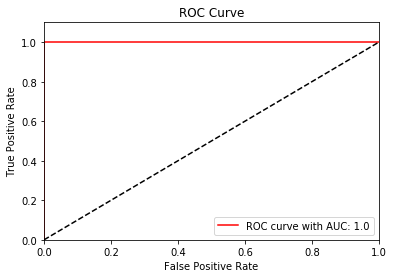

In [25]:
# predictions on testing data
predictedY = logRegModel.predict(LRTestDataX)

# Confusion Matrix
print('CONFUSION MATRIX FOR TESTING DATA:')
LRTrueNegative, LRFalsePositive, LRFalseNegative, LRTruePositive = confusion_matrix(LRTestDataY, predictedY).ravel()
printConfusionMatrix(LRTrueNegative, LRFalsePositive, LRFalseNegative, LRTruePositive)

# AUC value on training data
predictedYProb = logRegModel.predict_proba(LRTestDataX)[::,1]
LRfpr, LRtpr, _ = roc_curve(LRTestDataY,  predictedYProb)
LRTestAUC = round(roc_auc_score(LRTestDataY, predictedYProb), 3)
print('AREA UNDER CURVE FOR TESTING DATA:')
print(LRTestAUC)
print('------------------------------------------------------------------')

# ROC curve
print('ROC FOR TESTING DATA:')
plt.plot(LRfpr, LRtpr, color='red', label='ROC curve with AUC: ' + str(LRTestAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

## **Findings:** 
Yes, the classes (bending and non-bending) are imbalanced. There are only 4 samples of bending class, as compared to 15 samples of non-bending class in test data.

# Logistic Regression model based on case-control sampling and report the confusion matrix, ROC, and AUC of the model.

In [26]:
newTrainX = trainDataL[LRBestL][bestSelectedFeatures]
newTrainY = trainDataL[LRBestL]['Activity']

nonBCnt = 0
bCnt = 0
for i in range(0, len(newTrainY)):
    if newTrainY[i]==0:
        nonBCnt += 1
    else:
        bCnt += 1 

print('------------------------------------------------------------------')
print('Before Over-sampling, number of bending observations:', bCnt)
print('Before Over-sampling, number of non-bending observations:', nonBCnt)
print('------------------------------------------------------------------')

sm = SMOTE(sampling_strategy='all')
sampledTrainX, sampledTrainY = sm.fit_sample(newTrainX, newTrainY.ravel())

sampledNonBCnt = 0
sampledBCnt = 0
for i in range(0, len(sampledTrainY)):
    if sampledTrainY[i]==0:
        sampledNonBCnt += 1
    else:
        sampledBCnt += 1 

print('------------------------------------------------------------------')
print('After Over-sampling, number of bending observations:', sampledBCnt)
print('After Over-sampling, number of non-bending observations:', sampledNonBCnt)
print('------------------------------------------------------------------')

------------------------------------------------------------------
Before Over-sampling, number of bending observations: 9
Before Over-sampling, number of non-bending observations: 60
------------------------------------------------------------------
------------------------------------------------------------------
After Over-sampling, number of bending observations: 60
After Over-sampling, number of non-bending observations: 60
------------------------------------------------------------------


------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
1.0
------------------------------------------------------------------
CONFUSION MATRIX FOR TRAINING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |        60         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         0         |          60           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
AREA UNDER CURVE FOR TRAINING DATA:
1.0
------------------------------------------------------------------
ROC FOR TRAINING DATA:


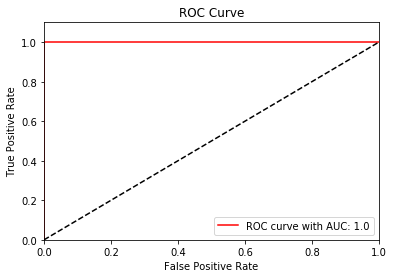

In [27]:
logRegBalancedModel = LogisticRegression(solver='liblinear', C=sys.maxsize)
logRegBalancedModel = logRegBalancedModel.fit(sampledTrainX, sampledTrainY)

# Accuracy on train data
LRBalancedTrainAccuracy = logRegBalancedModel.score(sampledTrainX, sampledTrainY)
LRBalancedTrainAccuracy = round(LRBalancedTrainAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TRAINING DATA:')
print(LRBalancedTrainAccuracy)
print('------------------------------------------------------------------')

# predictions on testing data
predictedTrainY = logRegBalancedModel.predict(sampledTrainX)

# Confusion Matrix
print('CONFUSION MATRIX FOR TRAINING DATA:')
trueNegative, falsePositive, falseNegative, truePositive = confusion_matrix(sampledTrainY, predictedTrainY).ravel()
printConfusionMatrix(trueNegative, falsePositive, falseNegative, truePositive)
print('------------------------------------------------------------------')
    
predictedTrainYProb = logRegBalancedModel.predict_proba(sampledTrainX)[::,1]
fpr, tpr, _ = roc_curve(sampledTrainY,  predictedTrainYProb)
LRBalancedTrainAUC = round(roc_auc_score(sampledTrainY, predictedTrainYProb), 3)

# AUC value
print('AREA UNDER CURVE FOR TRAINING DATA:')
print(LRBalancedTrainAUC)
print('------------------------------------------------------------------')

# ROC curve
print('ROC FOR TRAINING DATA:')
plt.plot(fpr, tpr, color='red', label='ROC curve with AUC: ' + str(LRBalancedTrainAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

------------------------------------------------------------------
ACCURACY FOR TESTING DATA:
0.895
------------------------------------------------------------------
CONFUSION MATRIX FOR TESTING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |         4         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         2         |          13           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
AREA UNDER CURVE FOR TESTING DATA:
1.0
------------------------------------------------------------------
ROC FOR TESTING DATA:


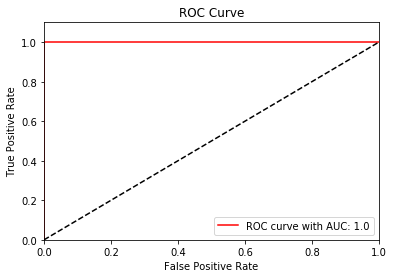

In [28]:
# Accuracy on test data
LRBalancedTestAccuracy = logRegBalancedModel.score(LRTestDataX, LRTestDataY)
LRBalancedTestAccuracy = round(LRBalancedTestAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TESTING DATA:')
print(LRBalancedTestAccuracy)
print('------------------------------------------------------------------')

# predictions on testing data
predictedY = logRegBalancedModel.predict(LRTestDataX)

# Confusion Matrix
print('CONFUSION MATRIX FOR TESTING DATA:')
trueNegative, falsePositive, falseNegative, truePositive = confusion_matrix(LRTestDataY, predictedY).ravel()
printConfusionMatrix(trueNegative, falsePositive, falseNegative, truePositive)
print('------------------------------------------------------------------')
    
predictedYProb = logRegBalancedModel.predict_proba(LRTestDataX)[::,1]
fpr, tpr, _ = roc_curve(LRTestDataY,  predictedYProb)
LRBalancedAUC = round(roc_auc_score(LRTestDataY, predictedYProb), 3)

# AUC value
print('AREA UNDER CURVE FOR TESTING DATA:')
print(LRBalancedAUC)
print('------------------------------------------------------------------')

# ROC curve
print('ROC FOR TESTING DATA:')
plt.plot(fpr, tpr, color='red', label='ROC curve with AUC: ' + str(LRBalancedAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

# Find best L and Tuning Paramater Lambda for Binary Classification using L1-Penalized Logistic Regression.

In [29]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

L1PenalizedData = []
L1PenalizedTrainData = {}
l1LambdaL = {}
for L in range(1, 21):
    featuresToPlot = []
    L1TrainDataDF = []

    for k,v in trainData.items():
        activity = k.split('/')[1]
        splits = np.array_split(v, L)
        row = []
        splitNum = 1
        for split in splits:
            stats = getStatistics(split)
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for i in range(0, 6):
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])  
                    
            splitNum += 1

        if activity=='bending1' or activity=='bending2':
            row.append(1)
        else:
            row.append(0)
        L1TrainDataDF.append(row)
        
    featuresToPlot.append('Activity')
    L1TrainDataDF = pd.DataFrame(L1TrainDataDF, columns=featuresToPlot)
    
    # normalize data
    norm1 = preprocessing.MinMaxScaler()
    norm = norm1.fit_transform(L1TrainDataDF.values)
    L1TrainDataDF = pd.DataFrame(norm, columns=L1TrainDataDF.columns)
    
    accuracy = []
    areaUnderCurve = []
    l1Lambda = []
    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    for trainIdx, valIdx in stratifiedKFolds.split(L1TrainDataDF[featuresToPlot], L1TrainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(L1TrainDataDF[featuresToPlot].iloc[idx])    
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)
        
        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(L1TrainDataDF[featuresToPlot].iloc[idx])    
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)
        
        # Fit regularized logistic regression
        L1LogRegModel = LogisticRegressionCV(cv=5, solver='liblinear', penalty='l1', max_iter=1000)
        L1LogRegModel = L1LogRegModel.fit(trainX, trainY)
        penalty = L1LogRegModel.C_[0]
        lambdaVal = round(float(1/penalty), 3)
        
        # Cross-validation accuracy and auc
        L1ValidationAccuracy = L1LogRegModel.score(valX, valY)
        predictedYProb = L1LogRegModel.predict_proba(valX)[::,1]
        fpr, tpr, _ = roc_curve(valY,  predictedYProb)
        L1ValidationAUC = roc_auc_score(valY, predictedYProb)
        
        accuracy.append(L1ValidationAccuracy)
        areaUnderCurve.append(L1ValidationAUC)
        l1Lambda.append(lambdaVal)
        
    row = []
    row.append(L)
    row.append(np.mean(accuracy))
    row.append(np.mean(areaUnderCurve))
    kFoldIdx = np.argmax(areaUnderCurve)
    l1LambdaL[L] = l1Lambda[kFoldIdx]
    trainDataL[L] = trainDataDF
    
    L1PenalizedData.append(row)
    L1PenalizedTrainData[L] = L1TrainDataDF
    
tableHeaders = ['L', 'Accuracy', 'AUC']
printDatainTable(tableHeaders, L1PenalizedData)

+====+==========+=======+
| L  | Accuracy |  AUC  |
+====+==========+=======+
| 1  |  0.913   | 0.967 |
+----+----------+-------+
| 2  |  0.943   | 0.925 |
+----+----------+-------+
| 3  |  0.929   | 0.975 |
+----+----------+-------+
| 4  |  0.957   | 0.992 |
+----+----------+-------+
| 5  |  0.885   | 0.917 |
+----+----------+-------+
| 6  |  0.914   | 0.942 |
+----+----------+-------+
| 7  |  0.927   | 0.967 |
+----+----------+-------+
| 8  |  0.913   | 0.942 |
+----+----------+-------+
| 9  |  0.913   | 0.95  |
+----+----------+-------+
| 10 |  0.929   | 0.95  |
+----+----------+-------+
| 11 |  0.899   | 0.883 |
+----+----------+-------+
| 12 |  0.914   | 0.917 |
+----+----------+-------+
| 13 |  0.899   | 0.917 |
+----+----------+-------+
| 14 |  0.913   | 0.908 |
+----+----------+-------+
| 15 |  0.913   | 0.933 |
+----+----------+-------+
| 16 |  0.913   | 0.933 |
+----+----------+-------+
| 17 |  0.927   | 0.908 |
+----+----------+-------+
| 18 |  0.929   | 0.95  |
+----+------

In [30]:
L1MaxAUC = L1PenalizedData[0][2]
L1BestL = L1PenalizedData[0][0]
bestLambda = L1PenalizedData[0][1]
for i in range(0, len(L1PenalizedData)):
    if L1PenalizedData[i][2]>L1MaxAUC:
        L1MaxAUC = L1PenalizedData[i][2]
        L1BestL = L1PenalizedData[i][0]
        
bestLambda = l1Lambda[L1BestL]
    
print('------------------------------------------------------------------')
print('BEST L based on AUC:', L1BestL)
print('------------------------------------------------------------------')

print('Best Lambda:', bestLambda)
print('------------------------------------------------------------------')

------------------------------------------------------------------
BEST L based on AUC: 4
------------------------------------------------------------------
Best Lambda: 0.046
------------------------------------------------------------------


------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
1.0
------------------------------------------------------------------
CONFUSION MATRIX FOR TRAINING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |         9         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         0         |          60           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
AREA UNDER CURVE FOR TRAINING DATA:
1.0
------------------------------------------------------------------
ROC FOR TRAINING DATA:


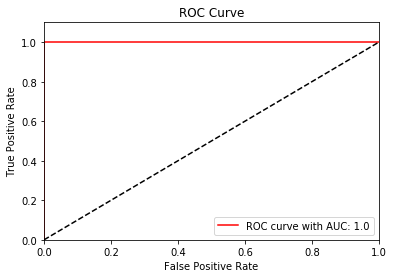

In [31]:
L1TrainDataDF = L1PenalizedTrainData[L1BestL]
L1TrainDataY = pd.DataFrame(L1TrainDataDF['Activity'])
L1TrainDataX = L1TrainDataDF.drop('Activity', axis=1)

L1TrainDataY = np.array(L1TrainDataY).flatten()

bestCVal = round(float(1/bestLambda), 3)
L1Model = LogisticRegression(solver='liblinear', penalty='l1', C=bestCVal)
L1Model = L1Model.fit(L1TrainDataX, L1TrainDataY)

L1TrainAccuracy = L1Model.score(L1TrainDataX, L1TrainDataY)
L1TrainAccuracy = round(L1TrainAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TRAINING DATA:')
print(L1TrainAccuracy)
print('------------------------------------------------------------------')

# predictions on training data
L1PredictedY = L1Model.predict(L1TrainDataX)

# Confusion Matrix
print('CONFUSION MATRIX FOR TRAINING DATA:')
L1TrueNegative, L1FalsePositive, L1FalseNegative, L1TruePositive = confusion_matrix(L1TrainDataY, L1PredictedY).ravel()
printConfusionMatrix(L1TrueNegative, L1FalsePositive, L1FalseNegative, L1TruePositive)
print('------------------------------------------------------------------')
    
L1PredictedYProb = L1Model.predict_proba(L1TrainDataX)[::,1]
L1fpr, L1tpr, _ = roc_curve(L1TrainDataY,  L1PredictedYProb)
L1TrainAUC = round(roc_auc_score(L1TrainDataY, L1PredictedYProb), 3)

# AUC value
print('AREA UNDER CURVE FOR TRAINING DATA:')
print(L1TrainAUC)
print('------------------------------------------------------------------')

# ROC curve
print('ROC FOR TRAINING DATA:')
plt.plot(L1fpr, L1tpr, color='red', label='ROC curve with AUC: ' + str(L1TrainAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

------------------------------------------------------------------
ACCURACY FOR TESTING DATA:
0.947
------------------------------------------------------------------
CONFUSION MATRIX FOR TESTING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |         3         |           1           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         0         |          15           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
AREA UNDER CURVE FOR TESTING DATA:
0.967
------------------------------------------------------------------
ROC FOR TESTING DATA:


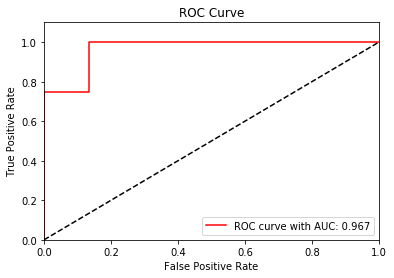

In [32]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
L1TestDataDF = []
for k,v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, L1BestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L1BestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])  

        splitNum += 1

    if activity=='bending1' or activity=='bending2':
        row.append(1)
    else:
        row.append(0)
    L1TestDataDF.append(row)

featuresToPlot.append('Activity')
L1TestDataDF = pd.DataFrame(L1TestDataDF, columns=featuresToPlot)

# normalize data
norm1 = preprocessing.MinMaxScaler()
norm = norm1.fit_transform(L1TestDataDF.values)
L1TestDataDF = pd.DataFrame(norm, columns=L1TestDataDF.columns)

L1TestDataY = pd.DataFrame(L1TestDataDF['Activity'])
L1TestDataX = L1TestDataDF.drop('Activity', axis=1)

L1TestAccuracy = L1Model.score(L1TestDataX, L1TestDataY)
L1TestAccuracy = round(L1TestAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TESTING DATA:')
print(L1TestAccuracy)
print('------------------------------------------------------------------')

# predictions on testing data
L1PredictedY = L1Model.predict(L1TestDataX)

# Confusion Matrix
print('CONFUSION MATRIX FOR TESTING DATA:')
L1TrueNegative, L1FalsePositive, L1FalseNegative, L1TruePositive = confusion_matrix(L1TestDataY, L1PredictedY).ravel()
printConfusionMatrix(L1TrueNegative, L1FalsePositive, L1FalseNegative, L1TruePositive)
print('------------------------------------------------------------------')
    
L1PredictedYProb = L1Model.predict_proba(L1TestDataX)[::,1]
L1fpr, L1tpr, _ = roc_curve(L1TestDataY,  L1PredictedYProb)
L1TestAUC = round(roc_auc_score(L1TestDataY, L1PredictedYProb), 3)

# AUC value
print('AREA UNDER CURVE FOR TESTING DATA:')
print(L1TestAUC)
print('------------------------------------------------------------------')

# ROC curve
print('ROC FOR TESTING DATA:')
plt.plot(L1fpr, L1tpr, color='red', label='ROC curve with AUC: ' + str(L1TestAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

# Compare L1-penalized with variable selection using p-values.

In [33]:
tableData = []
row1 = []
row1.append('Training Accuracy')
row1.append(LRTrainAccuracy)
row1.append(L1TrainAccuracy)
tableData.append(row1)

row2 = []
row2.append('Training AUC')
row2.append(LRTrainAUC)
row2.append(L1TrainAUC)
tableData.append(row2)

row3 = []
row3.append('Testing Accuracy')
row3.append(LRTestAccuracy)
row3.append(L1TestAccuracy)
tableData.append(row3)

row4 = []
row4.append('Testing AUC')
row4.append(LRTestAUC)
row4.append(L1TestAUC)
tableData.append(row4)

tableHeaders = ['Parameter', 'Logistic Regression', 'L1-Penalised Logistic Regression']
printDatainTable(tableHeaders, tableData)

+===================+=====================+==================================+
|     Parameter     | Logistic Regression | L1-Penalised Logistic Regression |
+===================+=====================+==================================+
| Training Accuracy |         1.0         |               1.0                |
+-------------------+---------------------+----------------------------------+
|   Training AUC    |         1.0         |               1.0                |
+-------------------+---------------------+----------------------------------+
| Testing Accuracy  |        0.895        |              0.947               |
+-------------------+---------------------+----------------------------------+
|    Testing AUC    |         1.0         |              0.967               |
+-------------------+---------------------+----------------------------------+


## **Findings:** 
The L-1 penalised Logistic Regression model is easier to implement because we just have to add one regularization parameter. The testing accuracy for L1-penalised Logistic Regression model is much better than Logistic Regression with variable selection. Hence, L1-penalised Logistic Regression model performs better for this dataset.

# Find best L and Tuning Paramater Lambda for Multi-Class Classification using L1-Penalized Logistic Regression.

In [34]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

MultiL1PenalizedData = []
MultiL1PenalizedTrainData = {}
multiL1Penalties = {}
for L in range(1, 21):
    featuresToPlot = []
    MultiL1TrainDataDF = []

    for k,v in trainData.items():
        activity = k.split('/')[1]
        splits = np.array_split(v, L)
        row = []
        splitNum = 1
        for split in splits:
            stats = getStatistics(split)
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for i in range(0, 6):
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])  
                    
            splitNum += 1

        idx = directoryToRead.index(activity)
        row.append(idx)
        MultiL1TrainDataDF.append(row)
        
    featuresToPlot.append('Activity')
    MultiL1TrainDataDF = pd.DataFrame(MultiL1TrainDataDF, columns=featuresToPlot)
   
    # normalize data
    norm1 = preprocessing.MinMaxScaler()
    norm = norm1.fit_transform(MultiL1TrainDataDF[featuresToPlot[:len(featuresToPlot)-1]].values)
    normalizedDF = pd.DataFrame(norm, columns=featuresToPlot[:len(featuresToPlot)-1])
    MultiL1TrainDataDF = normalizedDF.join(MultiL1TrainDataDF['Activity'])
        
    accuracy = []
    l1Penalties = []
    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    for trainIdx, valIdx in stratifiedKFolds.split(MultiL1TrainDataDF[featuresToPlot], MultiL1TrainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(MultiL1TrainDataDF[featuresToPlot].iloc[idx])    
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)
        
        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(MultiL1TrainDataDF[featuresToPlot].iloc[idx])    
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)
        
        # Fit regularized logistic regression
        MultiL1LogRegModel = LogisticRegressionCV(cv=5, 
                                                  solver='liblinear', 
                                                  penalty='l1', 
                                                  max_iter=1000,
                                                 multi_class='auto')
        MultiL1LogRegModel = MultiL1LogRegModel.fit(trainX, trainY)
        penalties = MultiL1LogRegModel.C_
        
        # Cross-validation accuracy
        MultiL1ValidationAccuracy = MultiL1LogRegModel.score(valX, valY)
        
        accuracy.append(MultiL1ValidationAccuracy)
        l1Penalties.append(penalties)
        
    row = []
    row.append(L)
    row.append(np.mean(accuracy))
    kFoldIdx = np.argmax(accuracy)
    multiL1Penalties[L] = l1Penalties[kFoldIdx]
    trainDataL[L] = trainDataDF
    
    MultiL1PenalizedData.append(row)    
    MultiL1PenalizedTrainData[L] = MultiL1TrainDataDF
    
tableHeaders = ['L', 'Accuracy']
printDatainTable(tableHeaders, MultiL1PenalizedData)

+====+==========+
| L  | Accuracy |
+====+==========+
| 1  |  0.868   |
+----+----------+
| 2  |  0.757   |
+----+----------+
| 3  |  0.797   |
+----+----------+
| 4  |  0.676   |
+----+----------+
| 5  |  0.765   |
+----+----------+
| 6  |  0.688   |
+----+----------+
| 7  |  0.638   |
+----+----------+
| 8  |  0.619   |
+----+----------+
| 9  |  0.674   |
+----+----------+
| 10 |  0.705   |
+----+----------+
| 11 |  0.633   |
+----+----------+
| 12 |   0.66   |
+----+----------+
| 13 |  0.611   |
+----+----------+
| 14 |  0.609   |
+----+----------+
| 15 |  0.636   |
+----+----------+
| 16 |  0.636   |
+----+----------+
| 17 |  0.691   |
+----+----------+
| 18 |  0.617   |
+----+----------+
| 19 |  0.611   |
+----+----------+
| 20 |  0.699   |
+----+----------+


In [35]:
MultiL1MaxAccuracy = MultiL1PenalizedData[0][1]
MultiL1MaxAccuracy = round(MultiL1MaxAccuracy, 3)
MultiL1BestL = MultiL1PenalizedData[0][0]
for i in range(0, len(MultiL1PenalizedData)):
    if MultiL1PenalizedData[i][1]>MultiL1MaxAccuracy:
        MultiL1MaxAccuracy = MultiL1PenalizedData[i][1]
        MultiL1MaxAccuracy = round(MultiL1MaxAccuracy, 3)
        MultiL1BestL = MultiL1PenalizedData[i][0]
        
MultiBestPenalties = multiL1Penalties[MultiL1BestL]
    
print('------------------------------------------------------------------')
print('BEST L ON MULTICLASS LOGISTIC REGRESSION:', MultiL1BestL)
print('------------------------------------------------------------------')
print('BEST LAMBDA ON MULTICLASS LOGISTIC REGRESSION:')
tableData = []
for i in range(0, len(MultiBestPenalties)):
    row = []
    row.append(directoryToRead[i])
    row.append(round(float(1/MultiBestPenalties[i]), 3))
    tableData.append(row)
tableHeaders = ['Class Name', 'Lambda']
printDatainTable(tableHeaders, tableData)
print('------------------------------------------------------------------------------')
print('BEST CROSS-VALIDATION ACCURACY ON MULTICLASS LOGISTIC REGRESSION:', MultiL1MaxAccuracy)
print('------------------------------------------------------------------------------')

------------------------------------------------------------------
BEST L ON MULTICLASS LOGISTIC REGRESSION: 1
------------------------------------------------------------------
BEST LAMBDA ON MULTICLASS LOGISTIC REGRESSION:
+============+========+
| Class Name | Lambda |
+============+========+
|  bending1  | 0.359  |
+------------+--------+
|  bending2  | 0.046  |
+------------+--------+
|  cycling   | 0.046  |
+------------+--------+
|   lying    | 0.046  |
+------------+--------+
|  sitting   | 0.046  |
+------------+--------+
|  standing  | 0.046  |
+------------+--------+
|  walking   | 0.359  |
+------------+--------+
------------------------------------------------------------------------------
BEST CROSS-VALIDATION ACCURACY ON MULTICLASS LOGISTIC REGRESSION: 0.868
------------------------------------------------------------------------------


In [36]:
MultiL1TrainDataDF = MultiL1PenalizedTrainData[MultiL1BestL]
MultiL1TrainDataY = pd.DataFrame(MultiL1TrainDataDF['Activity'])
MultiL1TrainDataX = MultiL1TrainDataDF.drop('Activity', axis=1)

MultiL1TrainDataY = np.array(MultiL1TrainDataY).flatten()

MultiL1ModelClass = []
for i in range(0, len(directoryToRead)):
    className = directoryToRead[i]
    MultiBestCVal = MultiBestPenalties[i]
    MultiL1NewTrainDataY = []
    for j in range(0, len(MultiL1TrainDataY)):
        if MultiL1TrainDataY[j]==i:
            MultiL1NewTrainDataY.append(1)
        else:
            MultiL1NewTrainDataY.append(0)
            
    MultiL1ModelClassI = LogisticRegression(solver='liblinear', 
                                  penalty='l1', 
                                  C=MultiBestCVal,
                                 multi_class='auto')
    
    MultiL1ModelClassI = MultiL1ModelClassI.fit(MultiL1TrainDataX, MultiL1NewTrainDataY)
    MultiL1ModelClass.append(MultiL1ModelClassI)

    
multiL1TrainPredictions, trainPredictionProbability = getMultiClassPredictions(MultiL1ModelClass, MultiL1TrainDataX) 

cnt = 0
for i in range(0, len(multiL1TrainPredictions)):
    if multiL1TrainPredictions[i]==MultiL1TrainDataY[i]:
        cnt += 1

MultiL1TrainAccuracy = round(cnt/len(MultiL1TrainDataY), 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TRAINING DATA ON MULTICLASS LOGISTIC REGRESSION:')
print(MultiL1TrainAccuracy)
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TRAINING DATA ON MULTICLASS LOGISTIC REGRESSION:
0.971
------------------------------------------------------------------


# Test Error for L1-Penalised Multi-Class Logistic Regression.

In [37]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
MultiL1TestDataDF = []
for k,v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, MultiL1BestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*MultiL1BestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])  

        splitNum += 1

    idx = directoryToRead.index(activity)
    row.append(idx)
    MultiL1TestDataDF.append(row)

featuresToPlot.append('Activity')
MultiL1TestDataDF = pd.DataFrame(MultiL1TestDataDF, columns=featuresToPlot)

# normalize data
norm1 = preprocessing.MinMaxScaler()
norm = norm1.fit_transform(MultiL1TestDataDF[featuresToPlot[:len(featuresToPlot)-1]].values)
normalizedDF = pd.DataFrame(norm, columns=featuresToPlot[:len(featuresToPlot)-1])
MultiL1TestDataDF = normalizedDF.join(MultiL1TestDataDF['Activity'])
      
MultiL1TestDataY = pd.DataFrame(MultiL1TestDataDF['Activity'])
MultiL1TestDataX = MultiL1TestDataDF.drop('Activity', axis=1)

# get predictions on test data
multiL1TestPredictions, testPredictionProbability = getMultiClassPredictions(MultiL1ModelClass, MultiL1TestDataX)

cnt = 0
for i in range(0, len(multiL1TestPredictions)):
    if multiL1TestPredictions[i]==MultiL1TestDataY['Activity'][i]:
        cnt += 1

MultiL1TestAccuracy = round(cnt/len(MultiL1TestDataY), 3)
multiL1TestError = round(1-MultiL1TestAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:')
print(MultiL1TestAccuracy)
print('------------------------------------------------------------------')
print('ERROR FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:')
print(multiL1TestError)
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:
0.842
------------------------------------------------------------------
ERROR FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:
0.158
------------------------------------------------------------------


# ROC and Confusion Matrix for Multiclass Logistic Regression.

ROC FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:


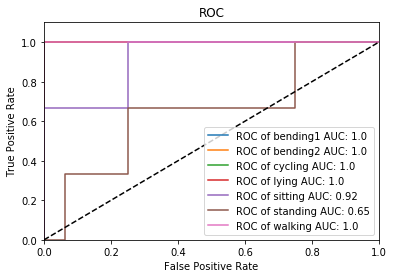

In [38]:
print('ROC FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:')
multiL1TestY = []
for i in range(0, len(MultiL1TestDataY)):
    row = []
    for j in range(0, 7):
        row.append(0)
    row[MultiL1TestDataY['Activity'][i]] = 1
    multiL1TestY.append(row)

multiL1TestY = pd.DataFrame(multiL1TestY, columns=directoryToRead)
predictedProbY = testPredictionProbability

fpr = {}
tpr = {}
multiclassAUC = {}
for i in range(0, len(directoryToRead)):
    fpr[i], tpr[i], _ = roc_curve(multiL1TestY[directoryToRead[i]], predictedProbY[directoryToRead[i]])
    multiclassAUC[i] = round(auc(fpr[i], tpr[i]), 2)

for i in range(0, 7):
    className = directoryToRead[i]
    label = 'ROC of ' + className + ' AUC: ' + str(multiclassAUC[i])
    plt.plot(fpr[i], tpr[i], label=label)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

In [39]:
MultiL1TestDataY = np.array(MultiL1TestDataY).flatten()

MultiL1ConfusionMatrix = confusion_matrix(MultiL1TestDataY, multiL1TestPredictions)
tableData = []
for i in range(0, len(MultiL1ConfusionMatrix)):
    row = np.array(MultiL1ConfusionMatrix[i], dtype='str')
    row = np.insert(row, 0, 'Actual ' + directoryToRead[i])
    tableData.append(row)
    
tableHeaders = []
tableHeaders.append('')
for i in range(0, len(directoryToRead)):
    tableHeaders.append('Predicted ' + directoryToRead[i])
print('CONFUSION MATRIX FOR MULTICLASS LOGISTIC REGRESSION:')
printDatainTable(tableHeaders, tableData)

CONFUSION MATRIX FOR MULTICLASS LOGISTIC REGRESSION:
+============+=============+===========+===========+==========+===========+===========+============+
|            | Predicted b | Predicted | Predicted | Predicte | Predicted | Predicted | Predicted  |
|            |   ending1   |  bending2 |  cycling  | d lying  |  sitting  |  standing |  walking   |
+============+=============+===========+===========+==========+===========+===========+============+
| Actual ben |      1      |     0     |     0     |    0     |     1     |     0     |     0      |
|   ding1    |             |           |           |          |           |           |            |
+------------+-------------+-----------+-----------+----------+-----------+-----------+------------+
| Actual ben |      0      |     2     |     0     |    0     |     0     |     0     |     0      |
|   ding2    |             |           |           |          |           |           |            |
+------------+-------------+----------

# Multi-Class Classification using Gaussian Naive Bayes Classifier.

In [40]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

GaussianData = []
GaussianTrainData = {}
for L in range(1, 21):
    featuresToPlot = []
    GaussianTrainDataDF = []

    for k,v in trainData.items():
        activity = k.split('/')[1]
        splits = np.array_split(v, L)
        row = []
        splitNum = 1
        for split in splits:
            stats = getStatistics(split)
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for i in range(0, 6):
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])  
                    
            splitNum += 1

        idx = directoryToRead.index(activity)
        row.append(idx)
        GaussianTrainDataDF.append(row)
        
    featuresToPlot.append('Activity')
    GaussianTrainDataDF = pd.DataFrame(GaussianTrainDataDF, columns=featuresToPlot)
       
    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    accuracy = []
    for trainIdx, valIdx in stratifiedKFolds.split(GaussianTrainDataDF[featuresToPlot], GaussianTrainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(GaussianTrainDataDF[featuresToPlot].iloc[idx])    
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)
        
        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(GaussianTrainDataDF[featuresToPlot].iloc[idx])    
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)
        
        # Fit gaussian naive bayes classifier
        gaussianModel = GaussianNB()
        gaussianModel = gaussianModel.fit(trainX, trainY)
        
        # Cross-validation accuracy
        GaussianValidationAccuracy = gaussianModel.score(valX, valY)
        accuracy.append(GaussianValidationAccuracy)
        
    row = []
    row.append(L)
    row.append(round(np.mean(accuracy), 3))
    GaussianData.append(row)
        
    GaussianTrainData[L] = GaussianTrainDataDF
    
tableHeaders = ['L', 'Accuracy']
printDatainTable(tableHeaders, GaussianData)

+====+==========+
| L  | Accuracy |
+====+==========+
| 1  |  0.836   |
+----+----------+
| 2  |  0.811   |
+----+----------+
| 3  |  0.798   |
+----+----------+
| 4  |  0.765   |
+----+----------+
| 5  |  0.803   |
+----+----------+
| 6  |  0.786   |
+----+----------+
| 7  |  0.765   |
+----+----------+
| 8  |  0.753   |
+----+----------+
| 9  |  0.793   |
+----+----------+
| 10 |   0.81   |
+----+----------+
| 11 |  0.743   |
+----+----------+
| 12 |  0.781   |
+----+----------+
| 13 |  0.744   |
+----+----------+
| 14 |  0.781   |
+----+----------+
| 15 |  0.758   |
+----+----------+
| 16 |   0.77   |
+----+----------+
| 17 |  0.753   |
+----+----------+
| 18 |   0.77   |
+----+----------+
| 19 |  0.746   |
+----+----------+
| 20 |  0.741   |
+----+----------+


In [41]:
GaussianMaxAccuracy = GaussianData[0][1]
GaussianBestL = GaussianData[0][0]
for i in range(0, len(GaussianData)):
    if GaussianData[i][1]>GaussianMaxAccuracy:
        GaussianMaxAccuracy = GaussianData[i][1]
        GaussianBestL = GaussianData[i][0]

print('------------------------------------------------------------------')
print('BEST L:', GaussianBestL)
print('------------------------------------------------------------------')
print('Best Cross-Validation Accuracy:', GaussianMaxAccuracy)
print('------------------------------------------------------------------')

------------------------------------------------------------------
BEST L: 1
------------------------------------------------------------------
Best Cross-Validation Accuracy: 0.836
------------------------------------------------------------------


In [42]:
GaussianTrainDataDF = GaussianTrainData[GaussianBestL]
GaussianTrainDataY = pd.DataFrame(GaussianTrainDataDF['Activity'])
GaussianTrainDataX = GaussianTrainDataDF.drop('Activity', axis=1)

GaussianTrainDataY = np.array(GaussianTrainDataY).flatten()

finalGaussianModel = GaussianNB()
finalGaussianModel = finalGaussianModel.fit(GaussianTrainDataX, GaussianTrainDataY)

GaussianTrainAccuracy = finalGaussianModel.score(GaussianTrainDataX, GaussianTrainDataY)
GaussianTrainAccuracy = round(GaussianTrainAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TRAINING DATA:')
print(GaussianTrainAccuracy)
print('------------------------------------------------------------------')
print('ERROR FOR TRAINING DATA:')
print(round(1-GaussianTrainAccuracy, 3))
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
0.957
------------------------------------------------------------------
ERROR FOR TRAINING DATA:
0.043
------------------------------------------------------------------


In [43]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
GaussianTestDataDF = []
for k,v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, GaussianBestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*GaussianBestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])  

        splitNum += 1

    idx = directoryToRead.index(activity)
    row.append(idx)
    GaussianTestDataDF.append(row)

featuresToPlot.append('Activity')
GaussianTestDataDF = pd.DataFrame(GaussianTestDataDF, columns=featuresToPlot)

GaussianTestDataY = pd.DataFrame(GaussianTestDataDF['Activity'])
GaussianTestDataX = GaussianTestDataDF.drop('Activity', axis=1)

GaussianTestAccuracy = finalGaussianModel.score(GaussianTestDataX, GaussianTestDataY)
GaussianTestAccuracy = round(GaussianTestAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TESTING DATA:')
print(GaussianTestAccuracy)
print('------------------------------------------------------------------')
print('ERROR FOR TESTING DATA:')
print(round(1-GaussianTestAccuracy, 3))
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TESTING DATA:
0.842
------------------------------------------------------------------
ERROR FOR TESTING DATA:
0.158
------------------------------------------------------------------


# ROC and Confusion Matrix of Gaussian Naive Bayes.

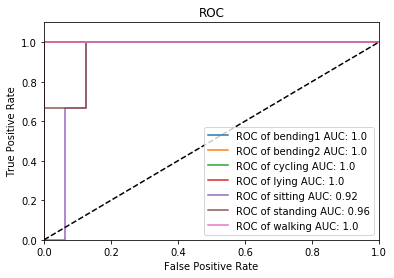

In [44]:
gaussianplt, gaussianAUC = multiClassROC(finalGaussianModel, GaussianTrainDataY, GaussianTestDataX, GaussianTestDataY)
gaussianplt.show()

In [45]:
GaussianPredictedY = finalGaussianModel.predict(GaussianTestDataX)
GaussianTestDataY = np.array(GaussianTestDataY).flatten()
gaussianConfusionMatrix = confusion_matrix(GaussianTestDataY, GaussianPredictedY)
tableData = []
for i in range(0, len(gaussianConfusionMatrix)):
    row = np.array(gaussianConfusionMatrix[i], dtype='str')
    row = np.insert(row, 0, 'Actual ' + directoryToRead[i])
    tableData.append(row)
    
tableHeaders = []
tableHeaders.append('')
for i in range(0, len(directoryToRead)):
    tableHeaders.append('Predicted ' + directoryToRead[i])
print('CONFUSION MATRIX FOR GAUSSIAN NAIVE BAYES CLASSIFIER:')
printDatainTable(tableHeaders, tableData)

CONFUSION MATRIX FOR GAUSSIAN NAIVE BAYES CLASSIFIER:
+============+=============+===========+===========+==========+===========+===========+============+
|            | Predicted b | Predicted | Predicted | Predicte | Predicted | Predicted | Predicted  |
|            |   ending1   |  bending2 |  cycling  | d lying  |  sitting  |  standing |  walking   |
+============+=============+===========+===========+==========+===========+===========+============+
| Actual ben |      2      |     0     |     0     |    0     |     0     |     0     |     0      |
|   ding1    |             |           |           |          |           |           |            |
+------------+-------------+-----------+-----------+----------+-----------+-----------+------------+
| Actual ben |      0      |     1     |     0     |    0     |     1     |     0     |     0      |
|   ding2    |             |           |           |          |           |           |            |
+------------+-------------+---------

# Multi-Class Classification using Multinomial Naive Bayes Classifier.

In [46]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

MultinomialData = []
MultinomialTrainData = {}
for L in range(1, 21):
    featuresToPlot = []
    MultinomialTrainDataDF = []

    for k,v in trainData.items():
        activity = k.split('/')[1]
        splits = np.array_split(v, L)
        row = []
        splitNum = 1
        for split in splits:
            stats = getStatistics(split)
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for i in range(0, 6):
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])  
                    
            splitNum += 1

        idx = directoryToRead.index(activity)
        row.append(idx)
        MultinomialTrainDataDF.append(row)
        
    featuresToPlot.append('Activity')
    MultinomialTrainDataDF = pd.DataFrame(MultinomialTrainDataDF, columns=featuresToPlot)
   
    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    accuracy = []
    for trainIdx, valIdx in stratifiedKFolds.split(MultinomialTrainDataDF[featuresToPlot], MultinomialTrainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(MultinomialTrainDataDF[featuresToPlot].iloc[idx])    
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)
        
        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(MultinomialTrainDataDF[featuresToPlot].iloc[idx])    
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)
        
        # Fit multinomial naive bayes classifier
        MultinomialModel = MultinomialNB()
        MultinomialModel = MultinomialModel.fit(trainX, trainY)
        
        # Cross-validation accuracy
        MultinomialValidationAccuracy = MultinomialModel.score(valX, valY)
        accuracy.append(MultinomialValidationAccuracy)
        
    row = []
    row.append(L)
    row.append(round(np.mean(accuracy), 3))
    MultinomialData.append(row)
        
    MultinomialTrainData[L] = MultinomialTrainDataDF
    
tableHeaders = ['L', 'Accuracy']
printDatainTable(tableHeaders, MultinomialData)

+====+==========+
| L  | Accuracy |
+====+==========+
| 1  |  0.798   |
+----+----------+
| 2  |   0.81   |
+----+----------+
| 3  |  0.798   |
+----+----------+
| 4  |  0.826   |
+----+----------+
| 5  |  0.815   |
+----+----------+
| 6  |  0.793   |
+----+----------+
| 7  |  0.781   |
+----+----------+
| 8  |  0.798   |
+----+----------+
| 9  |  0.781   |
+----+----------+
| 10 |  0.793   |
+----+----------+
| 11 |   0.81   |
+----+----------+
| 12 |  0.798   |
+----+----------+
| 13 |  0.776   |
+----+----------+
| 14 |  0.793   |
+----+----------+
| 15 |  0.793   |
+----+----------+
| 16 |  0.776   |
+----+----------+
| 17 |  0.776   |
+----+----------+
| 18 |  0.793   |
+----+----------+
| 19 |  0.781   |
+----+----------+
| 20 |  0.765   |
+----+----------+


In [47]:
MultinomialMaxAccuracy = MultinomialData[0][1]
MultinomialBestL = MultinomialData[0][0]
for i in range(0, len(MultinomialData)):
    if MultinomialData[i][1]>MultinomialMaxAccuracy:
        MultinomialMaxAccuracy = MultinomialData[i][1]
        MultinomialBestL = MultinomialData[i][0]

print('------------------------------------------------------------------')
print('BEST L:', MultinomialBestL)
print('------------------------------------------------------------------')
print('Best Cross-Validation Accuracy:', MultinomialMaxAccuracy)
print('------------------------------------------------------------------')

------------------------------------------------------------------
BEST L: 4
------------------------------------------------------------------
Best Cross-Validation Accuracy: 0.826
------------------------------------------------------------------


In [48]:
MultinomialTrainDataDF = MultinomialTrainData[MultinomialBestL]
MultinomialTrainDataY = pd.DataFrame(MultinomialTrainDataDF['Activity'])
MultinomialTrainDataX = MultinomialTrainDataDF.drop('Activity', axis=1)

MultinomialTrainDataY = np.array(MultinomialTrainDataY).flatten()

finalMultinomialModel = MultinomialNB()
finalMultinomialModel = finalMultinomialModel.fit(MultinomialTrainDataX, MultinomialTrainDataY)

MultinomialTrainAccuracy = finalMultinomialModel.score(MultinomialTrainDataX, MultinomialTrainDataY)
MultinomialTrainAccuracy = round(MultinomialTrainAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TRAINING DATA:')
print(MultinomialTrainAccuracy)
print('------------------------------------------------------------------')
print('ERROR FOR TRAINING DATA:')
print(round(1-MultinomialTrainAccuracy, 3))
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
0.928
------------------------------------------------------------------
ERROR FOR TRAINING DATA:
0.072
------------------------------------------------------------------


In [49]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
MultinomialTestDataDF = []
for k,v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, MultinomialBestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*MultinomialBestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])  

        splitNum += 1

    idx = directoryToRead.index(activity)
    row.append(idx)
    MultinomialTestDataDF.append(row)

featuresToPlot.append('Activity')
MultinomialTestDataDF = pd.DataFrame(MultinomialTestDataDF, columns=featuresToPlot)
      
MultinomialTestDataY = pd.DataFrame(MultinomialTestDataDF['Activity'])
MultinomialTestDataX = MultinomialTestDataDF.drop('Activity', axis=1)

MultinomialTestAccuracy = finalMultinomialModel.score(MultinomialTestDataX, MultinomialTestDataY)
MultinomialTestAccuracy = round(MultinomialTestAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TESTING DATA:')
print(MultinomialTestAccuracy)
print('------------------------------------------------------------------')
print('ERROR FOR TESTING DATA:')
print(round(1-MultinomialTestAccuracy, 3))
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TESTING DATA:
0.842
------------------------------------------------------------------
ERROR FOR TESTING DATA:
0.158
------------------------------------------------------------------


# ROC and Confusion Matrix of Multinomial Naive Bayes.

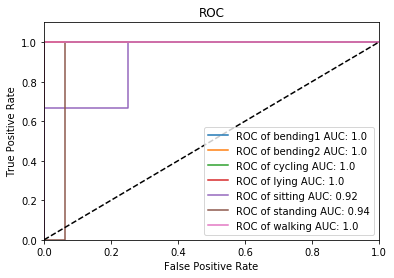

In [50]:
multinomialplt, multinomialAUC = multiClassROC(finalMultinomialModel, MultinomialTrainDataY, MultinomialTestDataX, MultinomialTestDataY)
multinomialplt.show()

In [51]:
MultinomialPredictedY = finalMultinomialModel.predict(MultinomialTestDataX)
MultinomialTestDataY = np.array(MultinomialTestDataY).flatten()
MultinomialConfusionMatrix = confusion_matrix(MultinomialTestDataY, MultinomialPredictedY)
tableData = []
for i in range(0, len(MultinomialConfusionMatrix)):
    row = np.array(MultinomialConfusionMatrix[i], dtype='str')
    row = np.insert(row, 0, 'Actual ' + directoryToRead[i])
    tableData.append(row)
    
tableHeaders = []
tableHeaders.append('')
for i in range(0, len(directoryToRead)):
    tableHeaders.append('Predicted ' + directoryToRead[i])
print('CONFUSION MATRIX FOR MULTINOMIAL NAIVE BAYES CLASSIFIER:')
printDatainTable(tableHeaders, tableData)

CONFUSION MATRIX FOR MULTINOMIAL NAIVE BAYES CLASSIFIER:
+============+=============+===========+===========+==========+===========+===========+============+
|            | Predicted b | Predicted | Predicted | Predicte | Predicted | Predicted | Predicted  |
|            |   ending1   |  bending2 |  cycling  | d lying  |  sitting  |  standing |  walking   |
+============+=============+===========+===========+==========+===========+===========+============+
| Actual ben |      2      |     0     |     0     |    0     |     0     |     0     |     0      |
|   ding1    |             |           |           |          |           |           |            |
+------------+-------------+-----------+-----------+----------+-----------+-----------+------------+
| Actual ben |      1      |     1     |     0     |    0     |     0     |     0     |     0      |
|   ding2    |             |           |           |          |           |           |            |
+------------+-------------+------

# Comparison between Multiclass Logistic Regression, Gaussian Naive Bayes and Multinomial Naive Bayes Classifier.

In [52]:
tableHeaders = ['Parameter', 'Multiclass Logistic Regression', 'Gaussian Naive Bayes', 'Multinomial Naive Bayes']
tableData = []
row1 = []
row1.append('Training Accuracy')
row1.append(MultiL1TrainAccuracy)
row1.append(GaussianTrainAccuracy)
row1.append(MultinomialTrainAccuracy)
tableData.append(row1)

row2 = []
row2.append('Testing Accuracy')
row2.append(MultiL1TestAccuracy)
row2.append(GaussianTestAccuracy)
row2.append(MultinomialTestAccuracy)
tableData.append(row2)

for i in range(0, 7):
    row = []
    row.append(directoryToRead[i] + ' AUC')
    row.append(multiclassAUC[i])
    row.append(gaussianAUC[i])
    row.append(multinomialAUC[i])
    tableData.append(row)
    
printDatainTable(tableHeaders, tableData)

+===================+===============================+======================+=======================+
|     Parameter     | Multiclass Logistic Regressio | Gaussian Naive Bayes | Multinomial Naive Bay |
|                   |               n               |                      |          es           |
+===================+===============================+======================+=======================+
| Training Accuracy |             0.971             |        0.957         |         0.928         |
+-------------------+-------------------------------+----------------------+-----------------------+
| Testing Accuracy  |             0.842             |        0.842         |         0.842         |
+-------------------+-------------------------------+----------------------+-----------------------+
|   bending1 AUC    |              1.0              |         1.0          |          1.0          |
+-------------------+-------------------------------+----------------------+---------------

Multinomial Naive Bayes Classifier is better for multi-class classification because the Area Under Curve for each class is better as compared to Gaussian Naive Bayes classifier and Multiclass Logistic Regression.